<a href="https://www.kaggle.com/code/bencaiello/fast-food-data-with-heavy-clean-up?scriptVersionId=141005105" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fast-food/FastFoodNutritionMenu.csv


# First Look
Now that the standard Kaggle import is done, let's open the file and look at it a bit

Note that some lines of code are commented out in this notebook (usually .info(), head(), or other similar calls that supply some information about the dataframe before/after changes) which I did to declutter the output after each cell.

In [2]:
#load file
file = pd.read_csv('/kaggle/input/fast-food/FastFoodNutritionMenu.csv')

#exploratory examination of file
display(file.head())
file.info()
#file.isna().sum()

,Company,Item,Calories,Calories from\nFat,Total Fat\n(g),Saturated Fat\n(g),Trans Fat\n(g),Cholesterol\n(mg),Sodium \n(mg),Carbs\n(g),Fiber\n(g),Sugars\n(g),Protein\n(g),Weight Watchers\nPnts
0,McDonald’s,Hamburger,250,80,9,3.5,0.5,25,520,31,2,6,12,247.5
1,McDonald’s,Cheeseburger,300,110,12,6,0.5,40,750,33,2,6,15,297
2,McDonald’s,Double Cheeseburger,440,210,23,11,1.5,80,1150,34,2,7,25,433
3,McDonald’s,McDouble,390,170,19,8,1,65,920,33,2,7,22,383
4,McDonald’s,Quarter Pounder® with Cheese,510,230,26,12,1.5,90,1190,40,3,9,29,502


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159 entries, 0 to 1158
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Company               1159 non-null   object
 1   Item                  1159 non-null   object
 2   Calories              1157 non-null   object
 3   Calories from
Fat     1098 non-null   object
 4   Total Fat
(g)         1101 non-null   object
 5   Saturated Fat
(g)     1101 non-null   object
 6   Trans Fat
(g)         1101 non-null   object
 7   Cholesterol
(mg)      1157 non-null   object
 8   Sodium 
(mg)          1157 non-null   object
 9   Carbs
(g)             1101 non-null   object
 10  Fiber
(g)             1101 non-null   object
 11  Sugars
(g)            1157 non-null   object
 12  Protein
(g)           1027 non-null   object
 13  Weight Watchers
Pnts  524 non-null    object
dtypes: object(14)
memory usage: 126.9+ KB


# Converting columns to numeric: checking what doesn't fit
All columns except Company / Item should be numeric (I will use float type) but are currently object type, so we will need to eventually convert them to float.

At the same time, I also want to know what is in my columns that aren't numeric, so I wrote a function that will reveal what kinds of values cannot be converted to float in each of these columns, so that I can see what other cleaning steps might be used to salvage data / determine whether other errors may be present:

In [3]:
def df_non_numeric_list(dataframe,column_exclusion_list=None):
    """ Print all unique values in a dataframe, by column, that cannot be converted to a float.
    
    Parameters
    ----------
    dataframe (pandas dataframe): required, the dataframe whose columns are to be analyzed for non-numeric convertible values
    column_exclusion_list (list): optional, a list of column names of those columns to be excluded from the analysis. Default value is None.
    
    Returns
    -------
    Prints: the name of each column in the dataframe, followed by a list of all the non-numeric convertible values in the column.
    """
    for column in dataframe.columns:
        error_list = []
        if column in column_exclusion_list:
            pass
        else:
            for element in dataframe[column]:
                try:
                    element_float = float(element)
                except:
                    error_list.append(element)
            print(column , ': ', pd.Series(error_list).unique())

#Check what non-numerics are hiding in the columns that ought to be numeric....
df_non_numeric_list(file,['Company','Item'])


Calories :  ['\xa0' 'Calories']
Calories from
Fat :  ['\xa0' 'Total Fat (g)']
Total Fat
(g) :  ['\xa0' 'Saturated Fat (g)']
Saturated Fat
(g) :  ['5.5 g' '\xa0' 'Trans Fat (g)']
Trans Fat
(g) :  ['\xa0' 'Cholesterol (mg)' '<5']
Cholesterol
(mg) :  ['\xa0' 'Sodium (mg)' '<5']
Sodium 
(mg) :  ['\xa0' 'Carbs (g)' '<1']
Carbs
(g) :  ['\xa0' 'Fiber (g)' '<1']
Fiber
(g) :  ['\xa0' 'Sugar (g)' '<1']
Sugars
(g) :  ['\xa0' 'Protein (g)' '<1']
Protein
(g) :  ['\xa0' 'Weight Watchers Pnts']
Weight Watchers
Pnts :  ['\xa0']


# The non-numeric values in the numerical columns: how to fix the easy ones
I found that the values in a non numeric-convertable form were either:
  
  '\xa0', 
 
 a column name (which usually did not match the parent column),
 
 '<1' or '<5', 
 
 plus one instance where the units were included with a usable number ('5.5 g')

In [4]:
#Simple cleaning
#Step 1: clean the '5.5g' data point in the saturated fat column
file['Saturated Fat\n(g)'] = file['Saturated Fat\n(g)'].str.replace('5.5 g','5.5')

#Step 2: convert all '\xa0' to NaN and all '<1' / '<5' to 0:
file_no_company_item = file.drop(['Company','Item'],axis=1)
for i in file_no_company_item.columns:
    change_list = []
    for j in file[i]:
        if j == '\xa0':
            change_list.append(np.nan)
        elif (j == '<1') | (j == '<5'):
            change_list.append(0)
        else:
            change_list.append(j) 
    file[i] = pd.Series(change_list)

#Confirm that the '<1','<5', and '5.5 g' are no longer in the dataframe using my previously defined function:
print('After fixing a number of the non-convertible items in the numeric columns: re-test to confirm they have been fixed: \n')
df_non_numeric_list(file,['Company','Item'])
#so now everything can be converted to float, except those strange column labels, which are also oddly in the wrong columns!

#check for duplicates, and remove (there are 7 duplicates, just like I saw another notebook find)
print(len(file))
file = file.drop_duplicates()
print(len(file))

#remove all rows where every value is NaN (except company/item). Examination of the csv in 
#excel (downloaded, personal computer) showed a good number of rows with only missing / 0 values.
#There is no point is keeping these rows or imputing any values to them as they contain no data.
#However, before I delete them I also want to save what items are being removed
file_no_company_item = file.drop(['Company','Item'],axis = 1)

file_company_item_only = file[['Company','Item']]
file_company_item_only_index = set(file.index)

file = file.dropna(subset = file_no_company_item.columns, how='all')

#uncomment to see the company/items removed by dropping "all NaN" rows
#removed_items = list(file_company_item_only_index.difference(set(file.index)))
#for i in removed_items:
#    print(file_company_item_only[file_company_item_only.index == i])

#check NaN's again
print("\n I've also removed some of the NaN's, but some remain")
#print(file.isna().sum(), len(file))

After fixing a number of the non-convertible items in the numeric columns: re-test to confirm they have been fixed: 

Calories :  ['Calories']
Calories from
Fat :  ['Total Fat (g)']
Total Fat
(g) :  ['Saturated Fat (g)']
Saturated Fat
(g) :  ['Trans Fat (g)']
Trans Fat
(g) :  ['Cholesterol (mg)']
Cholesterol
(mg) :  ['Sodium (mg)']
Sodium 
(mg) :  ['Carbs (g)']
Carbs
(g) :  ['Fiber (g)']
Fiber
(g) :  ['Sugar (g)']
Sugars
(g) :  ['Protein (g)']
Protein
(g) :  ['Weight Watchers Pnts']
Weight Watchers
Pnts :  []
1159
1152

 I've also removed some of the NaN's, but some remain


/tmp/ipykernel_20/2778423333.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  file['Saturated Fat\n(g)'] = file['Saturated Fat\n(g)'].str.replace('5.5 g','5.5')
/tmp/ipykernel_20/483474609.py:23: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  print(column , ': ', pd.Series(error_list).unique())


# Now to the big problem: inconsistent columns
Key points:

- We've removed duplicates, cleaned up the non-numeric-convertible values in all the columns (with one big exception...), and dropped rows of all NaN's

- The rows of all NaN's frequently look like headers of sections, by the their Company/Item values, or are drinks. Understanding the organization of some sections could be useful.

Now about those column names.... There is a huge problem with this file!

In [5]:
#Examination of the csv in excel also revealed a singular row with new labels -- 
#indicating a change in the identity of the columns(!!). Extract the row and examine:
pd.set_option('display.max_columns', None)
file_weird_row = file[file['Sugars\n(g)'] == 'Protein (g)']
print("There is a row in the dataset of all column names, after the Company/Item columns: \n")
print(file_weird_row) 
print('\n Note the index of 661, will look around the strange index to see what probably happened:\n')
print(file[(file.index > 655) & (file.index < 665)])

There is a row in the dataset of all column names, after the Company/Item columns: 

     Company                Item  Calories Calories from\nFat  \
661  Wendy’s  Wendy’s Kids’ Meal  Calories      Total Fat (g)   

        Total Fat\n(g) Saturated Fat\n(g)    Trans Fat\n(g) Cholesterol\n(mg)  \
661  Saturated Fat (g)      Trans Fat (g)  Cholesterol (mg)       Sodium (mg)   

    Sodium \n(mg) Carbs\n(g) Fiber\n(g)  Sugars\n(g)          Protein\n(g)  \
661     Carbs (g)  Fiber (g)  Sugar (g)  Protein (g)  Weight Watchers Pnts   

    Weight Watchers\nPnts  
661                   NaN  

 Note the index of 661, will look around the strange index to see what probably happened:

     Company                           Item  Calories Calories from\nFat  \
656  Wendy’s         Vanilla Frosty, Medium       450                 12   
657  Wendy’s          Vanilla Frosty, Small       340                  9   
658  Wendy’s         Chocolate Chunk Cookie       310                 16   
659  Wendy’s

# Confirming the problem: some companies don't give calories from fat data, but this shifts every following column in the dataset
Something is very wrong with this file...... not only does it appear that the columns shift, but remember than calories from fat roughly equals 9*grams of fat. 
However, see line 656 --> "calories from fat" column is 12, but the "grams of fat" is 8g -- this is impossible, and this repeates in all the visible columns of this slice (646--664). 
Similarly, the protein colum is >350, which is obviously wrong. This high of a number, does, however, match a weight watchers points score, not a protein (g) value.
This indicates a shift of values after the calories from fat column, which appears missing in these rows, even though the old column names persist in the data frame. 

One consequence of this shift is that all rows with this problem have NaN for the final weight watchers column, and the many rows of the protein column has an impossibly high values (>calories/4) because of the different scale of the weight watcher points.

Note that although the label change apparently occurs at index 661, the problem clearly precedes this index as well!

Finally, do note that the row with the new column labels does sitll have an item list -- the Wendy's kid's meal. This might shift the rows, although other items later in the list make sense ( such as small-medium-large following consistent calorie trends)

In [6]:
#Time to fix it!

#I leave in the following code, commented out, as a note of what I originally did, but looking at the file as a whole
# & in particular looking at the company-by-company entries, revelaed that the problem is based on what
#columns are there by company (with the Calories from fat column being absent from Wendy', KFC, and Pizza Hut
#data)

''' OLD ATTEMPT to fix via index:
#check for likely bad rows (see part of the logic from the prior cell):
#first remove weird row and convert to float so that conditional statements can be made:
file = file[file['Sugars\n(g)'] != 'Protein (g)']
for i in file_no_company_item.columns:
    file[i] = file[i].astype('float')

#next make the conditional statements, which slice the dataframe by each condition chosen:
w_w_pnts_NaN = file[file['Weight Watchers\nPnts'].isna()]  # the suspect columns have no values in this column
too_much_fat_for_fat_calories = file[(file['Calories from\nFat'].astype('float') / 8) < file['Total Fat\n(g)']] # having Calories from fat > 8*fat(g) should be impossible! I chose 8 instead of 9 grams since I think there is some variability in the conversion. 
too_much_protein_for_total_calories = file[(file['Calories'] / 4) < file['Protein\n(g)']]  # similarly, there cant be more protein than the total calories / 4

#overlap each condition, to retrieve the indexes where all three impossible conditions are met:
index_list = []
for i in w_w_pnts_NaN.index:
    if (i in too_much_fat_for_fat_calories.index) & (i in too_much_protein_for_total_calories.index):
        index_list.append(i) 

print(index_list)
#the problem appears to start at/around index 529
#but first check near index 529 to see if anything was missed:
print(file[(file.index > 515) & (file.index < 535)])
#weight watchers column ends abruptly at 529
#store critical index:
crit_ind = index_list[0]

# now shift all values after index 529 in columns after "calories from fat" over one, leaving the calories from fat column empty (all NaN)
#perhaps I do this the hard way, by breaking the dataframe into various pieces then putting them back together agin properly. (I'm new to datascience / python)

#make the latter half of the datafram, with / after the bad column, the values shifted to the proper columns:
columns_with_cal_fat_no_ww = file.columns[3:-1]
columns_after_cal_fat = file.columns[4:]
file_second_half = file[file.index > (crit_ind - 1)][columns_with_cal_fat_no_ww]

#rename columns
col_dict = {}
for ii,i in enumerate(columns_with_cal_fat_no_ww):
    col_dict[i] = columns_after_cal_fat[ii]

file_second_half = file_second_half.rename(columns = col_dict)
file_second_half['Calories from\nFat'] = np.nan

#take the first three (unaffected columns) of second half, then join it to the value columns:
file_first_three_columns_second_half = file[file.index > (crit_ind - 1)][file.columns[:3]]
file_second_half = pd.concat([file_second_half,file_first_three_columns_second_half], axis = 1)

#no need to change the first half of the data frame
file_first_half = file[file.index < crit_ind]

#finally join the two halves
file_reforged = pd.concat([file_first_half,file_second_half], axis = 0)

print(file_reforged)
'''

#New plan
#first remove weird row and convert to float for the future & so I can do description of the stats of the columns:
#I also got a strange result once from my later re-coding of the columns when I did not do this first, not sure how or if this is necessary
file = file[file['Sugars\n(g)'] != 'Protein (g)']
for i in file_no_company_item.columns:
    file[i] = file[i].astype('float')
    
#print(file.describe())
print('Look at which companies are affected by the column switch by looking for impossible values (like Cal-from-Fat / Total Fat << 9. or protein grams > about 100) and for all NaNs in the weightWatcher column \n')
companies = file['Company'].unique()
for i in companies:
    print(i, "--", file[file['Company'] == i][['Calories from\nFat','Total Fat\n(g)','Protein\n(g)','Weight Watchers\nPnts']].head(n=2))

Look at which companies are affected by the column switch by looking for impossible values (like Cal-from-Fat / Total Fat << 9. or protein grams > about 100) and for all NaNs in the weightWatcher column 

McDonald’s --    Calories from\nFat  Total Fat\n(g)  Protein\n(g)  Weight Watchers\nPnts
0                80.0             9.0          12.0                  247.5
1               110.0            12.0          15.0                  297.0
Burger King --      Calories from\nFat  Total Fat\n(g)  Protein\n(g)  Weight Watchers\nPnts
330               360.0            40.0          28.0                  655.0
331               420.0            46.0          32.0                  735.0
Wendy’s --      Calories from\nFat  Total Fat\n(g)  Protein\n(g)  Weight Watchers\nPnts
529                62.0            24.0         923.0                    NaN
530                51.0            20.0         789.0                    NaN
KFC --      Calories from\nFat  Total Fat\n(g)  Protein\n(g)  Weight

# Fixing the column values of the companies with shifted/incorrect data (KFC,Wendy's,Pizza Hut)
So the problem appears to be what each company chooses to report, with some leaving out calories from fat. Specifically, Wendy's KFC and pizza hut need their columns' values shifted (starting with the calories from fat column on), while the others can be left the same.

In [7]:
#Separate the improply ordered data and the properly ordered, by company:
correct_data_companies = [companies[0],"Burger King","Taco Bell"]
incorrect_data_companies = [companies[2],"KFC","Pizza Hut"]

slice_bad = file
for i in correct_data_companies:
    slice_bad = slice_bad[slice_bad['Company'] != i]

slice_good = file
for i in incorrect_data_companies:
    slice_good = slice_good[slice_good['Company'] != i]

# rename columns for the wrong half:
columns_with_cal_fat_no_ww = file.columns[3:-1]
columns_after_cal_fat = file.columns[4:]
col_dict = {"Weight Watchers\nPnts":"Calories from\nFat"}
for ii,i in enumerate(columns_with_cal_fat_no_ww):
    col_dict[i] = columns_after_cal_fat[ii]
slice_bad = slice_bad.rename(columns = col_dict)

#Finally rejoin and check the outcome
file_reforged = pd.concat([slice_good,slice_bad], axis = 0)
file_reforged.sort_index()

print('Look at descriptive stats to see if problem appears fixed (esp. in the max column, look for impossible-sounding numbers like hundreds of grams of protein, that might indicate unfixed rows). This also serves as a first look at the statistics of the data now that the numeric columns are properly constructed and their values have been converted to a numeric type. \n')
file_reforged.describe()


Look at descriptive stats to see if problem appears fixed (esp. in the max column, look for impossible-sounding numbers like hundreds of grams of protein, that might indicate unfixed rows). This also serves as a first look at the statistics of the data now that the numeric columns are properly constructed and their values have been converted to a numeric type. 



,Calories,Calories from\nFat,Total Fat\n(g),Saturated Fat\n(g),Trans Fat\n(g),Cholesterol\n(mg),Sodium \n(mg),Carbs\n(g),Fiber\n(g),Sugars\n(g),Protein\n(g),Weight Watchers\nPnts
count,1126.000000,623.000000,1072.000000,1072.000000,1072.000000,1126.000000,1126.000000,1072.000000,1072.000000,1126.000000,1072.000000,869.000000
mean,287.908526,118.033708,11.705690,4.077892,0.140858,40.235346,428.096803,39.023321,1.440299,23.831261,9.430970,311.142693
std,222.662374,132.463769,13.992975,5.038020,0.491031,67.979164,497.936655,31.728694,2.385409,32.346265,11.082784,239.340314
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,140.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,17.000000,0.000000,2.000000,0.000000,142.000000
50%,240.000000,80.000000,8.000000,3.000000,0.000000,20.000000,190.000000,34.000000,0.000000,8.000000,7.000000,274.000000
75%,390.000000,170.000000,18.000000,6.000000,0.000000,50.000000,680.000000,52.000000,2.000000,39.750000,14.000000,432.000000
max,1220.000000,750.000000,98.000000,33.000000,4.500000,575.000000,2890.000000,270.000000,31.000000,264.000000,71.000000,1317.000000


# Addressing the remaining Null values in the DataFrame
Looks better! Although one has to wonder what item has >264g of sugar(!!)....
Now I will drop all the NaN's (there are relatively few, less than 5% of the rows in the dataframe) except the NaN's in the Weight Watchers Points column, which I'll leave as is. 

Not only is the Weight Watchers column, from what I have seen, exclusively NaN for some companies (so I didn't want to impute a mean WW Points to those), but as we'll see later, the WW Points column does not convey much useful information beyond the information already captured by the Total Calories column of the dataframe (the two values correlate at 0.99!). 

In [8]:
# now that the dataframe has its substantial column issues fixed, it is time to look at those NaN's and deal with them
#print(file_reforged.isna().sum(), len(file_reforged))

# first, I will drop all the rows with NaNs below 5% of the columns (which is ~56, from 0.05*1126)
#then fill all the NaN's of the calories from fat with 9*total fat
# finally I will choose to bot impute the NaN's in the Weight Watchers column, as three of the companies simply have no data for that
cols_to_drop_NaN = ['Total Fat\n(g)','Saturated Fat\n(g)','Trans Fat\n(g)','Carbs\n(g)','Fiber\n(g)','Protein\n(g)']
file_reforged = file_reforged.dropna(subset=cols_to_drop_NaN)
file_reforged['Calories from\nFat'] = file_reforged['Calories from\nFat'].fillna(9 * file_reforged['Total Fat\n(g)'])

#print(file_reforged.isna().sum(), len(file_reforged))  
print('Have dropped all nulls except those in the Weight Watcher Points column: \n')
print(file_reforged.isna().sum())
# I can see the changes have taken effect -- now it time to finally plot something / move past data cleaning!

Have dropped all nulls except those in the Weight Watcher Points column: 

Company                    0
Item                       0
Calories                   0
Calories from\nFat         0
Total Fat\n(g)             0
Saturated Fat\n(g)         0
Trans Fat\n(g)             0
Cholesterol\n(mg)          0
Sodium \n(mg)              0
Carbs\n(g)                 0
Fiber\n(g)                 0
Sugars\n(g)                0
Protein\n(g)               0
Weight Watchers\nPnts    203
dtype: int64


# First Look at data: distribution of numerical variables

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


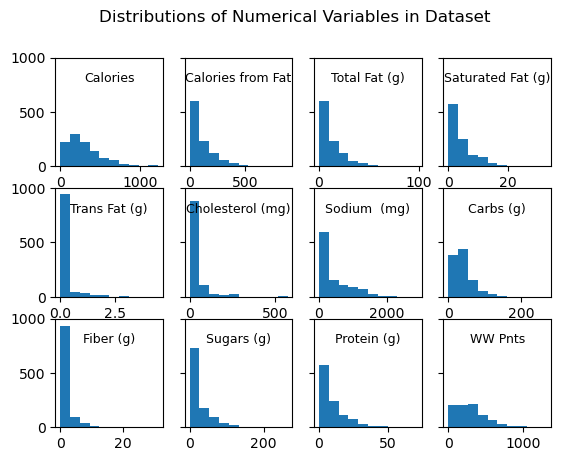

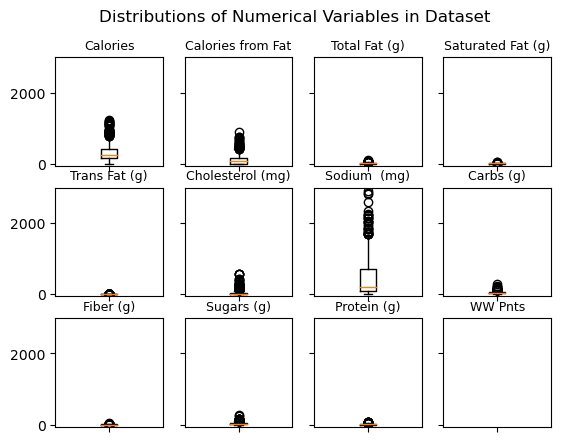

In [9]:
#time to look at the data for things of interest!
#But first, let's look at outliers

import matplotlib.pyplot as plt
import seaborn as sns

#Distributions of all the numerical data in the dataset

fig,ax = plt.subplots(nrows = 3,ncols = 4,sharey=True)
col = 2
for axs in ax.flat:
    axs.hist(file_reforged.iloc[:,col])
    axs.set_title(file_reforged.columns[col].replace('\n',' ').replace('Weight Watchers','WW'),size = 9,y = 0.7)
    axs.set_ylim(top = 1000)
    col += 1
fig.suptitle("Distributions of Numerical Variables in Dataset")
plt.show()

#boxplot
fig,ax = plt.subplots(nrows = 3,ncols = 4,sharey=True)
col = 2
for axs in ax.flat:
    axs.boxplot(file_reforged.iloc[:,col])
    axs.set_title(file_reforged.columns[col].replace('\n',' ').replace('Weight Watchers','WW'),size = 9,y = 1.0)
    axs.set_ylim(top = 3000)
    axs.set_xticklabels('')
    col += 1
fig.suptitle("Distributions of Numerical Variables in Dataset")
plt.show()

# Potentially useful Transformation: cubed-root

With the except of the total calories and WW pnts columns, the distributions visible above are very right-skewed and have lots of values piled up near 0 with large tails of higher-value outliers, so a transformation of the data may be useful. 

I tried a log-transformation first, but settled on a root transformation because the many zero values in the dataset (even with the addition of a small number like 0.0001 to avoid infinities) seemed to throw off the output for some of the downstream analysis I was doing. A cubed-root ended up being simpler to execute and appeared to convert the data to relatively normal distributions for most columns, except for the pile of values remaining at 0 in many of them:

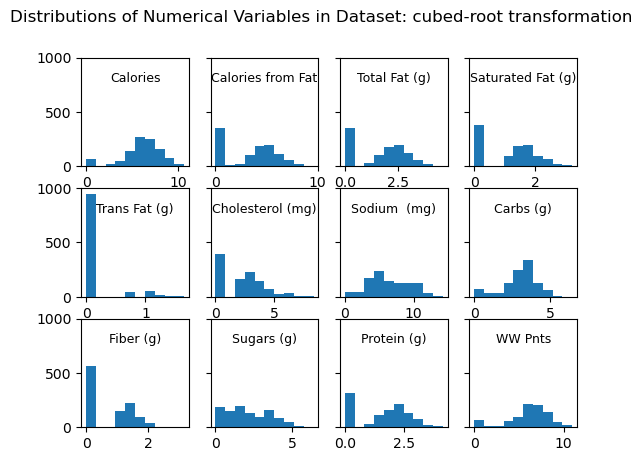

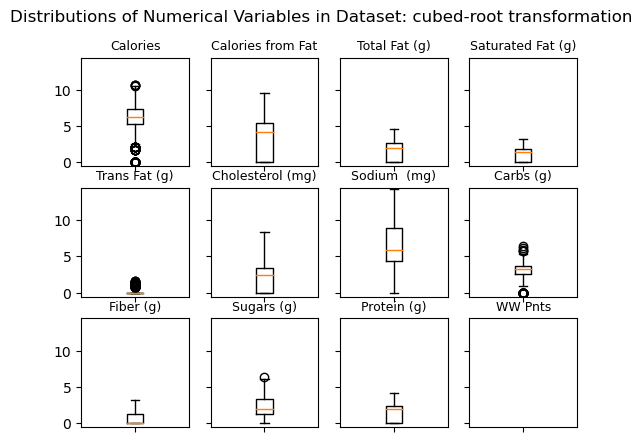

In [10]:
#Most of these are heavily right-skewed distributions, so let's transform them by taking the cubed root and see what happens:
file_re_trans = pd.DataFrame()
for i in file_no_company_item.columns:
    file_re_trans[i] = (file_reforged[i]) ** (1/3)

#Distributions of all the numerical data in the transformed dataset

fig,ax = plt.subplots(nrows = 3,ncols = 4,sharey=True)
col = 0
for axs in ax.flat:
    axs.hist(file_re_trans.iloc[:,col])
    axs.set_title(file_re_trans.columns[col].replace('\n',' ').replace('Weight Watchers','WW'),size = 9,y = 0.7)
    axs.set_ylim(top = 1000)
    col += 1
fig.suptitle("Distributions of Numerical Variables in Dataset: cubed-root transformation")
plt.show()

#boxplot
fig,ax = plt.subplots(nrows = 3,ncols = 4,sharey=True)
col = 0
for axs in ax.flat:
    axs.boxplot(file_re_trans.iloc[:,col])
    axs.set_title(file_re_trans.columns[col].replace('\n',' ').replace('Weight Watchers','WW'),size = 9,y = 1.0)
    axs.set_ylim(top = (3000 **(1/3)))
    axs.set_xticklabels('')
    col += 1
fig.suptitle("Distributions of Numerical Variables in Dataset: cubed-root transformation")
plt.show()
    

# Distributions of calories, sodium, and fiber by company

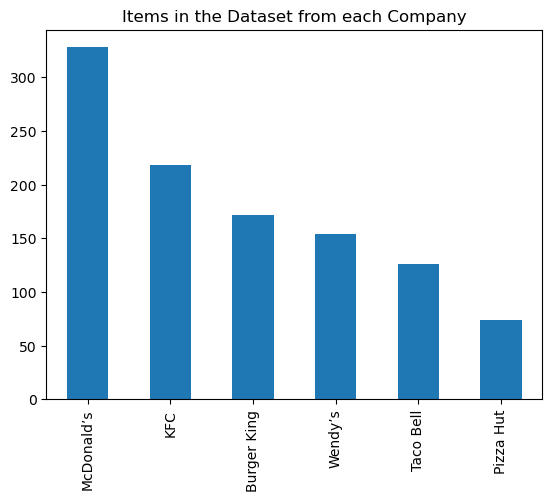

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


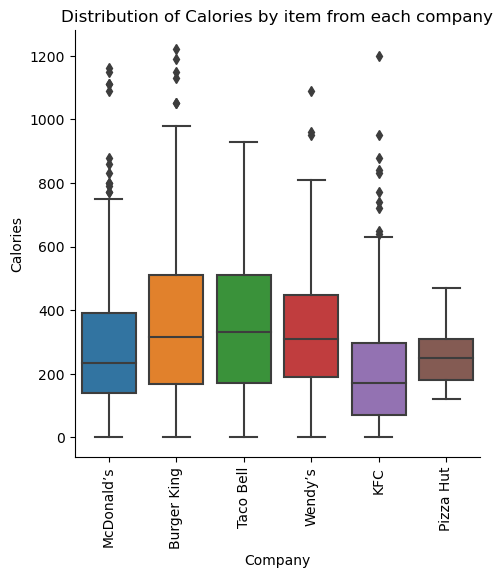

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


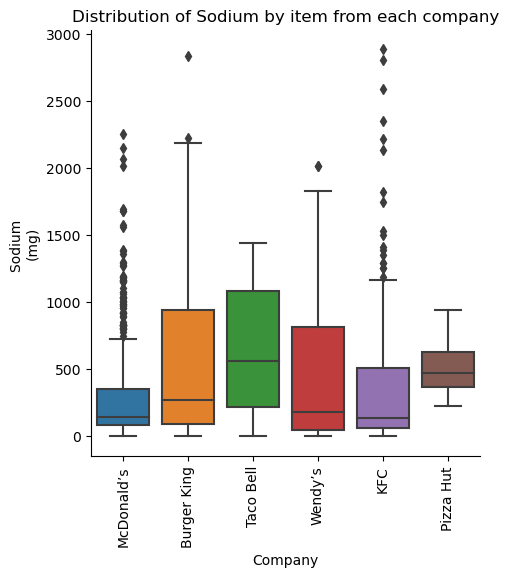

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


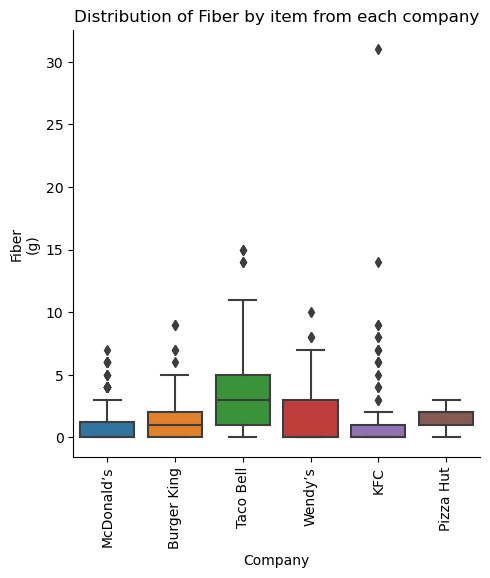

In [11]:
#Much better! If called for, we can always use a cubed-root transformation, but the transformed dataframe currently doesn't have the first two columns: 
file_re_trans['Company'] = file_reforged['Company']
file_re_trans['Item'] = file_reforged['Item']

#Although there are still some outliers in the data, I want to move on to visualization and analysis for now 

#The question is -- what do we what to know?
#I see other have split things up by company, so I'll look at that too
file_reforged['Company'].value_counts().plot(kind='bar')
plt.title("Items in the Dataset from each Company")
plt.show()

sns.catplot(kind='box',data=file_reforged,x='Company',y='Calories')
plt.xticks(rotation = 90)
plt.title("Distribution of Calories by item from each company")
plt.show()

sns.catplot(kind='box',data=file_reforged,x='Company',y='Sodium \n(mg)')
plt.xticks(rotation = 90)
plt.title("Distribution of Sodium by item from each company")
plt.show()

sns.catplot(kind='box',data=file_reforged,x='Company',y='Fiber\n(g)')
plt.xticks(rotation = 90)
plt.title("Distribution of Fiber by item from each company")
plt.show()






In [12]:
''' 
#but I also want to know about how many items are of different levels of calories, like sauces with very low calories, perhaps. I might use these later.
xlow_cal = file_reforged[file_reforged['Calories'] <= 50]

#could be good to exclude very low calorie items:
#cal_more_than_50 = file_reforged[file_reforged['Calories'] > 50]

low_cal = file_reforged[(file_reforged['Calories'] <= 150)  & (file_reforged['Calories'] > 50)]
med_cal = file_reforged[(file_reforged['Calories'] <= 450)  & (file_reforged['Calories'] > 150)]
high_cal = file_reforged[file_reforged['Calories'] > 450]
listy = [xlow_cal,low_cal,med_cal,high_cal]
title_list=['<50','50-150','150-450','>450']
#print(low_cal,len(low_cal))
for ii,i in enumerate(listy):
    corr = i.corr()
    sns.heatmap(corr,annot=True,linewidth=0.5,fmt = '0.2f')
    plt.title('Correlations of {} calorie items'.format(title_list[ii]))
    plt.show()
'''
print('Uncomment code, or run directly by highlight --> ctrl+shift+enter for a lot of heatmaps across the various categories of calorie content')

Uncomment code, or run directly by highlight --> ctrl+shift+enter for a lot of heatmaps across the various categories of calorie content


# Correlation visualizations

Let's see how the columns correlate with each other. This will also be useful for any downstream machine learning analysis, as we will be able to drop redundant columns.

/tmp/ipykernel_20/572084024.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = file_reforged.corr()


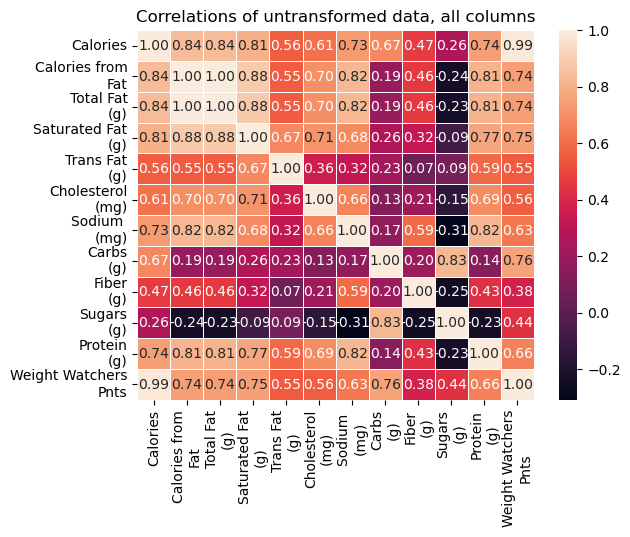

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


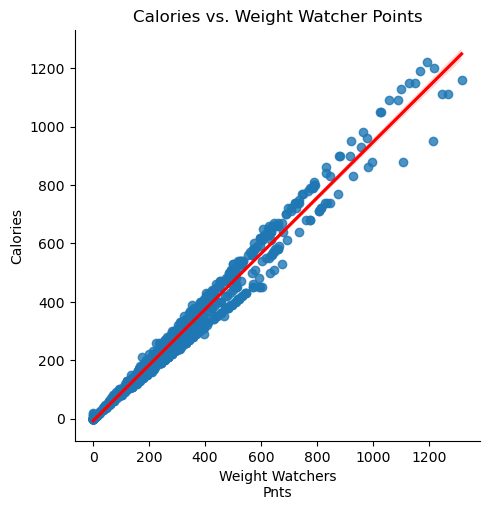

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


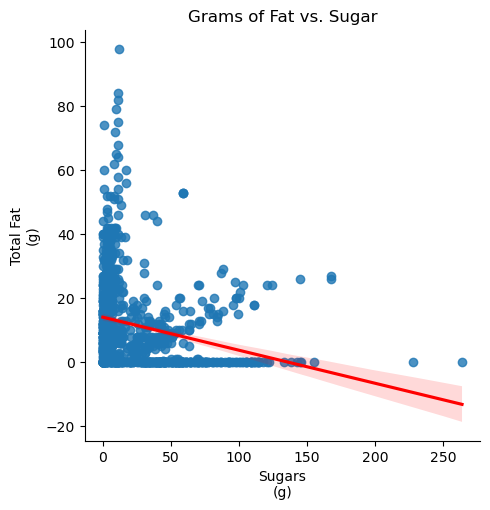

In [13]:

#Let's see if we can predict company from the characteristics of the items:
#First let's find highly correlated data and drop redundant/correlated columns
corr = file_reforged.corr()
sns.heatmap(corr,annot=True,linewidth=0.5,fmt = '0.2f')
plt.title('Correlations of untransformed data, all columns')
plt.show()


#almost all of the columns values are positively correlated (if weakly) with each other, except sugar

#some correlation comparisons

#Is the weight Watchers column just a proxy for total calories? will drop NaN rows
file_WW_comp = file_reforged.dropna(subset = 'Weight Watchers\nPnts')

sns.lmplot(data=file_WW_comp, x = 'Weight Watchers\nPnts',y = 'Calories',line_kws={'color':'r'})
plt.title('Calories vs. Weight Watcher Points')
plt.show()

#Fat vs. Sugar
sns.lmplot(data=file_reforged, x = 'Sugars\n(g)',y = 'Total Fat\n(g)',line_kws={'color':'r'})
plt.title('Grams of Fat vs. Sugar')
plt.show()




# Conclusion of correlation visualizations:
We can see that most measured values in the dataset correlate with each other positively, except sugar.
Interestingly, when we look at the scatter plot of sugar vs. fat quantities, we can see that the negative correlation is driven by a large number of items that are either predominantly fat with no sugar, or vice versa, seen by the points tightly hugging the x and y axes in the final figure of this section.

Another point of interest is that the "Weight Watchers Points" is extremely tightly correlated with total calories (correlation = 0.99), perhaps indicating that the Weight Watcher Points system is not contributing additional information about fast food items beyond total calorie count.



# Can we predict the company from the item characteristics?

Perhaps we can use machine learning to train an algorithm to identify the company name from the nutrient characteristics of the item.

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb


#preparefile

#print(file_re_trans.columns)  -- remembering the column names this deep in the notebook is easier if you print them...

#all the fat columns & Cholesterol are highly correlated, drop all except Total Fat
file_drop = file_re_trans.drop(['Saturated Fat\n(g)','Calories from\nFat','Cholesterol\n(mg)'],axis = 1)
#Weight Watcher points correlates extremely closely with total calories, also was imputed for half of the companies in the dataset,: also drop
file_drop = file_drop.drop(['Weight Watchers\nPnts'],axis = 1)

#let's do this only for the items > 50 Calories:
file_drop = file_drop[file_drop['Calories'] > (50**(1/3))]

SEED = 656

X = file_drop.drop(['Item','Company'],axis = 1)

y = file_drop['Company']
y = y.factorize()
y = y[0]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = SEED)

#let's see if we can identify companies from their items
sc = StandardScaler()
xg = xgb.XGBClassifier(objective = "reg:linear",random_state=SEED)
param = {"max_depth":[10,15,20],'n_estimators':[10,20],'gamma':[0.05,0.15,3]}
cv = GridSearchCV(xg,param_grid=param,cv = 5)

sc.fit_transform(X_train)
sc.transform(X_test)
model = cv.fit(X_train,y_train)
best = model.best_estimator_
best_param = model.best_params_
score = best.score(X_test,y_test)
print('For this model, I dropped items with total calories <50, dropped a number of redundant columns, and used the cubed-root transformed data. \n')
print('Best Scoring Model Accuracy:\n', score, '\n\n', 'Best Tested Parameters of the XGBoost model:', best_param)

For this model, I dropped items with total calories <50, dropped a number of redundant columns, and used the cubed-root transformed data. 

Best Scoring Model Accuracy:
 0.6440677966101694 

 Best Tested Parameters of the XGBoost model: {'gamma': 0.05, 'max_depth': 15, 'n_estimators': 20}


Not very good at predicting the company, with only ~64% accuracy! 
If I included items of <50 calories that accuracy score went down to 58%.
